In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Proposal Write Up

    For our proposal, we aim to explore whether a person’s starting and mid-career median salary can be used to predict which region of college they attended. We will be utilizing data sourced from The Wall Street Journal and Payscale Inc. Using our data, we will categorize many colleges across the United States by region, and our data set will also include the starting median salary for colleges, and the mid salary median for those colleges. The salaries are classified by the regions the colleges are located in. To address our proposed question, we will be using the K-nearest neighbors classification to predict the region of a new college based on salary data, utilizing the K-numbers of closest entry. 

	Our process revolves around utilizing three distinct columns from our data set: region, starting median salary, and mid-career median salary. The reason for using these specific variables is that they provide us with a more holistic view of alumni salaries. We also take use of the school name column by grouping by region for further analysis. The approach we’ll be taking will involve creating a K-nearest neighbors classification model with regions as the factor and the two salary variables are predictors. The data set will be divided into 5 subsets that will be tested against each other for internal consistency testing and to yield the most optimal K value. We will then use this K value for classification of a newly observed data set provided in another sheet from the website.

	To visualize our results, we will be generating a confusion matrix that will help us to have a comprehensive assessment of the classification model, including seeing the number of correct and false predictions. Once we create our comprehensive assessment, we can also assess our model’s accuracy, precision, and recalling by defining the positive object. Looking through our raw data, we can expect to see that some regions have a higher starting salary than others, so we can generalize and assume that a higher starting/middle salary would correspond to those said regions. These findings are significant, as we could use them as guidance strategies for educational investments and career guidance to enhance economic growth. Additionally, future research could explore the effects of industry distribution, local economies, and cost of living on regional salary outcomes for graduats. 


In [7]:
download.file("https://raw.githubusercontent.com/colinyee9935/DSCI100_Group_Project/main/data/salaries_by_region.csv", "salary_region.csv")
salary_region<-read_csv("salary_region.csv")

salary_region <- salary_region |>
    rename_with(~str_to_lower(.) |>              #reformat the column names into lower case and replace space with underscores
                str_replace_all("[^[:alnum:]]+", "_"), .cols = everything())|>
    mutate(mid_career_10th_percentile_salary = na_if(mid_career_10th_percentile_salary, "N/A"))|>
    mutate(mid_career_90th_percentile_salary = na_if(mid_career_90th_percentile_salary, "N/A"))|>

#turning column to dbl
    mutate(mid_career_10th_percentile_salary_d=as.numeric(mid_career_10th_percentile_salary))|>
    mutate(mid_career_90th_percentile_salary_d=as.numeric(mid_career_90th_percentile_salary))|>
    select(-mid_career_10th_percentile_salary,-mid_career_90th_percentile_salary)|>

#rearranging columns
    select(1:4, mid_career_10th_percentile_salary_d, everything(), mid_career_90th_percentile_salary_d)|>
    rename(midc_10th_salary = mid_career_10th_percentile_salary_d,
          midc_25th_salary= mid_career_25th_percentile_salary,
          midc_75th_salary=mid_career_75th_percentile_salary,
          midc_90th_salary=mid_career_90th_percentile_salary_d)
    

#    select(school_name:mid_career_median_salary)
salary_region

Rows: 320 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): School Name, Region, Mid-Career 10th Percentile Salary, Mid-Career ...
dbl (4): Starting Median Salary, Mid-Career Median Salary, Mid-Career 25th P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school_name,region,starting_median_salary,mid_career_median_salary,midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stanford University,California,70400,129000,68400,93100,184000,257000
California Institute of Technology (CIT),California,75500,123000,NA,104000,161000,NA
Harvey Mudd College,California,71800,122000,NA,96000,180000,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
State University of New York (SUNY) at Fredonia,Northeastern,37800,66200,32800,44200,93300,181000
University of Southern Maine,Northeastern,39400,63600,40400,47900,85700,117000
Mercy College,Northeastern,43700,62600,35600,47300,99000,134000


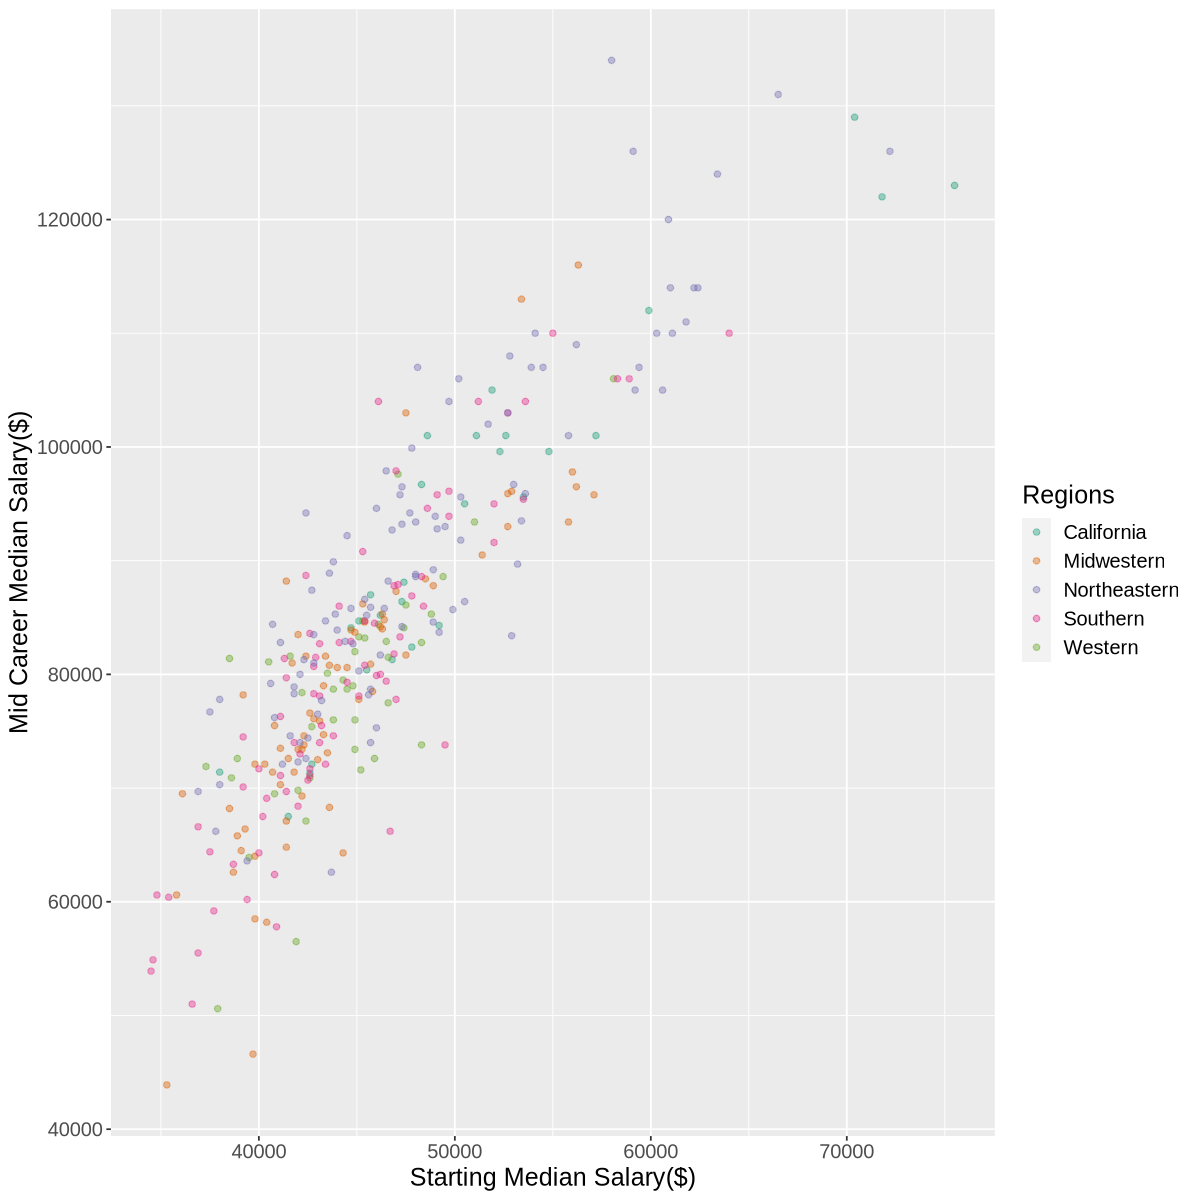

In [9]:
#graphing of data sets: starting median salary and mid career median salary
#distribution of the two definitive data we'll be using

options(repr.plot.width = 10, repr.plot.height = 10)

salary_region_graph<-salary_region|>
    ggplot(aes(x=starting_median_salary, y=mid_career_median_salary, color=region))+
    geom_point(alpha = 0.4)+
    labs(x="Starting Median Salary($)",
        y="Mid Career Median Salary($)",
        color="Regions")+
    scale_color_brewer(palette = "Dark2")+
    theme(text=element_text(size=15))

salary_region_graph

#the distribution has some distinct characteristics to it - a large group of data points are clustered in the box formulated by x(40000,50000) and y(70000,90000).
#Classification within this range might becomes obscure as data points affialited to each region is really close toghether
#Thus, we should be cautious with this and test-retest our model with different set when incorporating only these two data if we do not include percentile data columns

In [11]:
#investigate the number of observations in each region
#this is important in finding whether each group has sufficient data points for reference

region_count<-salary_region|>
    group_by(region)|>
    summarize(count=n())
region_count

#from the table below, we can see that there are an unbalance observation between regions
#Observations go as low as only 28 in California, which makes sense since it's only one state
#but since the socioeconomic status in Calfornia is largely different from many other states in the U.S.
#it's understandable that it stands on it's own, as it has almost the highest median income and best educational resources
#Observation go as high as 100 in Northeastern. This disparity in the number of observations post a potential confounding to our analysis,
#as it's going to affect the model which ultimately impact the predications. We need to procede with caution and be critical on our findings.

region,count
<chr>,<int>
California,28
Midwestern,71
Northeastern,100
Southern,79
Western,42


In [10]:
#counting the missing data points in certain columnds of the data table
#this is signigicant in deciding whether we should incorporate percentile column in our classification model for increasing accuracy

columns_to_check <- c("midc_10th_salary", "midc_25th_salary", "midc_75th_salary", "midc_90th_salary")

missing_counts <- salary_region |>
    summarize(across(all_of(columns_to_check), ~ sum(is.na(.), na.rm = TRUE)))
missing_counts

#The following table shows the number of missing data in each percentile salary column.
#We can see that for 10th, 90th percentile there are 47 missing data and none for the other two.
#This is about 15% of the entire set, which is quite a significant amount that poses potential confoundings in our model
#As for some regions that has lower number of observation, such as California, the issue becomes prominent as they are weighed less if a data is missing
#Nonetheless, we could incorporate 25th and 75th percentile to increase the accuracy of the data set as they contain no missing data.

midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<int>,<int>,<int>,<int>
47,0,0,47
